In [1]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv
import os
import glob
import pandas as pd
import time
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
from scipy.spatial.transform import Rotation as R
import ipywidgets as widgets
from ipywidgets import interactive

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [4]:
df = pd.read_csv(r"D:\FST_972_FF_Sphere\FST_972_Run\aerocoeff_df2.csv")

df.head()

,Time,X,Y,Z,Vx,Vy,Vz,Ax,Ay,Az,yaw,roll,pitch,C_D,C_L,C_z
0,55.08,6.897080,12.002743,2.616291,2.849603,-2.402818,3.518446,76.91427,-1.499417,30.788608,2.959416,-1.344324,-1.028525,0.432836,0.008438,0.173263
1,55.12,7.065294,12.026698,2.686268,3.442180,-1.395568,2.027872,76.91427,-1.499417,30.788608,3.055798,-1.244317,-1.009287,0.432836,0.008438,0.173263
2,55.16,7.171656,11.902388,2.831836,4.034758,-0.388318,0.537298,76.91427,-1.499417,30.788608,3.086846,-1.466701,-1.106401,0.432836,0.008438,0.173263
3,55.20,7.346494,11.884420,2.716885,4.534220,-0.072008,0.353039,76.91427,-1.499417,30.788608,3.145654,-1.446309,-1.163121,0.432836,0.008438,0.173263
4,55.24,7.563431,11.996219,2.708442,4.844475,-0.285297,0.716259,76.91427,-1.499417,30.788608,3.279278,-1.144457,-1.065323,0.432836,0.008438,0.173263


In [5]:
df.columns

Index(['Time', 'X', 'Y', 'Z', 'Vx', 'Vy', 'Vz', 'Ax', 'Ay', 'Az', 'yaw',
       'roll', 'pitch', 'C_D', 'C_L', 'C_z'],
      dtype='object')

In [6]:
time = df["Time"]
X = df["X"]
Y = df["Y"]
Z = df["Z"]
Vx = df["Vx"]
Vy = df["Vy"]
Vz = df["Vz"]
Ax = df["Ax"]
Ay = df["Ay"]
Az = df["Az"]

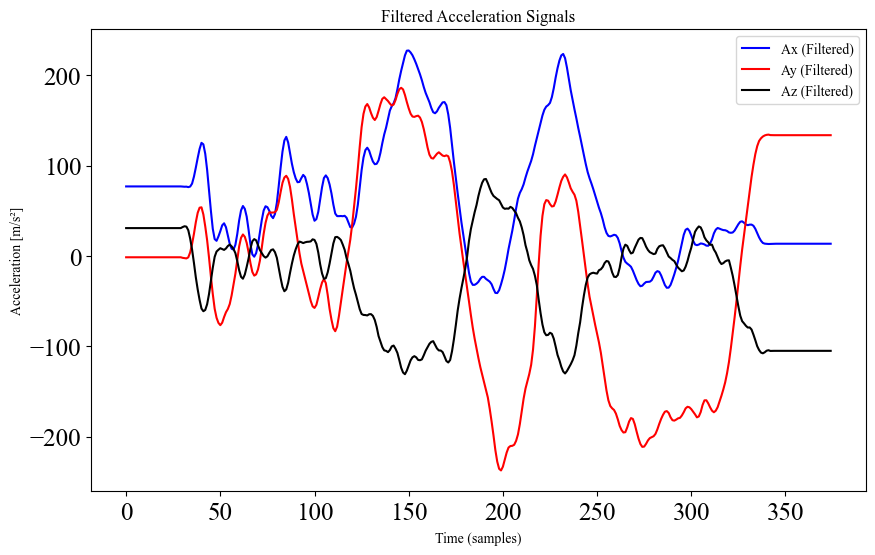

In [7]:
from scipy.signal import savgol_filter

def savitzky_golay_filter(data, window_length=10, polyorder=3):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

# Applying filters
ax_filtered = savitzky_golay_filter(Ax)
ay_filtered = savitzky_golay_filter(Ay)
az_filtered = savitzky_golay_filter(Az)

# Plotting the filtered signals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ax_filtered, label='Ax (Filtered)', color='blue')
plt.plot(ay_filtered, label='Ay (Filtered)', color='red')
plt.plot(az_filtered, label='Az (Filtered)', color='black')
plt.legend()
plt.title('Filtered Acceleration Signals')
plt.xlabel('Time (samples)')
plt.ylabel('Acceleration [m/s²]')
plt.show()


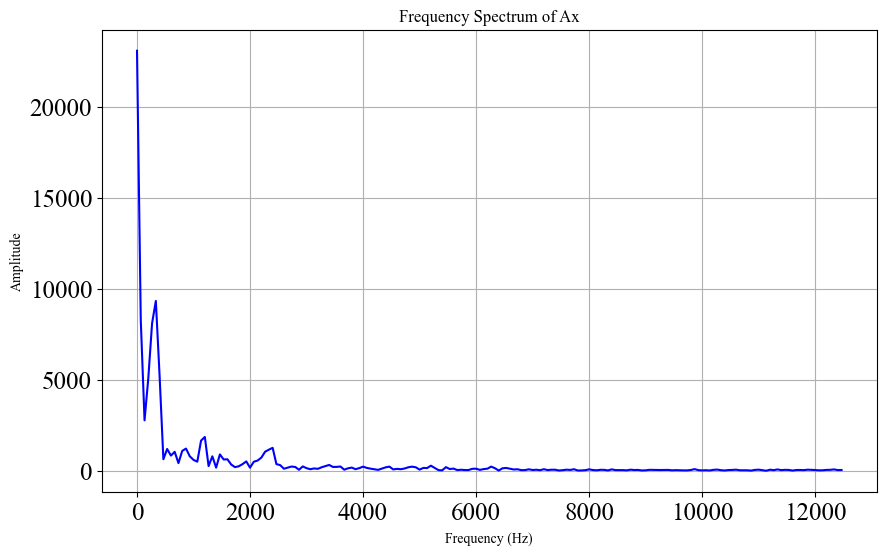

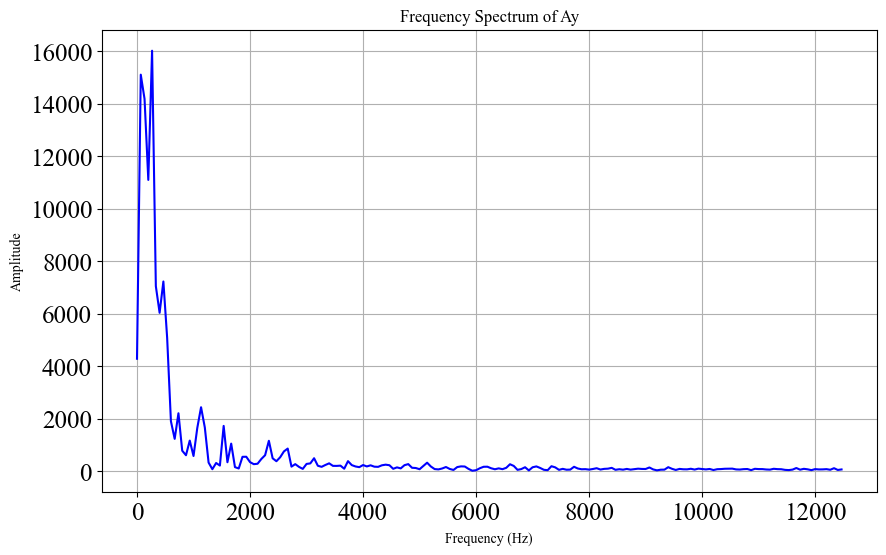

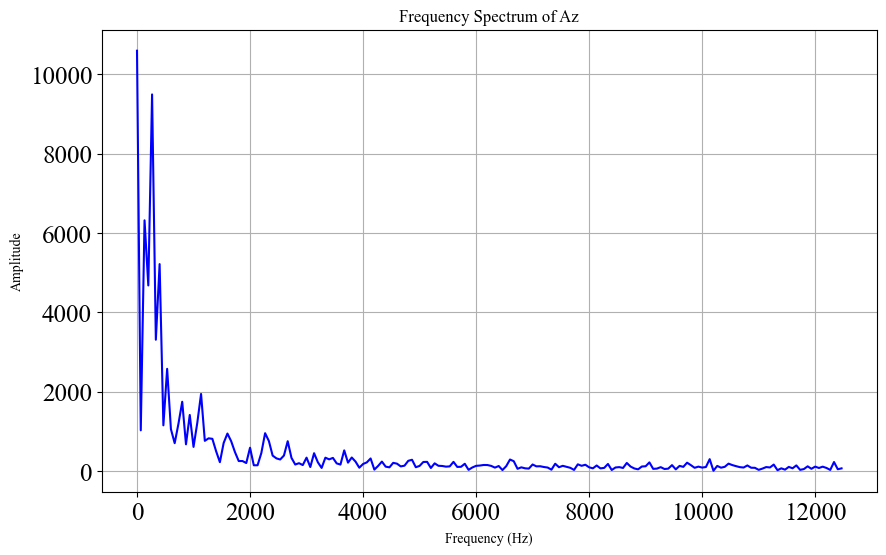

In [12]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_spectrum(data, fs, axis_name="Ax"):
    """
    Plot the frequency spectrum of a signal.
    
    Parameters:
        data (array-like): The signal to be analyzed.
        fs (float): Sampling frequency of the signal (Hz).
        axis_name (str): Name of the axis being plotted (Ax, Ay, Az, etc.)
    """
    # Number of samples
    N = len(data)
    
    # Perform the FFT
    yf = fft(data)
    xf = fftfreq(N, 1 / fs)
    
    # Only keep the positive frequencies
    indices = np.where(xf >= 0)
    xf = xf[indices]
    yf = np.abs(yf[indices])

    # Plot the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(xf, yf, color='blue')
    plt.title(f"Frequency Spectrum of {axis_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


fs = 25000  # Example: If you are sampling your data at 1000 Hz
plot_frequency_spectrum(Ax.to_numpy(), fs, axis_name="Ax")
plot_frequency_spectrum(Ay.to_numpy(), fs, axis_name="Ay")
plot_frequency_spectrum(Az.to_numpy(), fs, axis_name="Az")


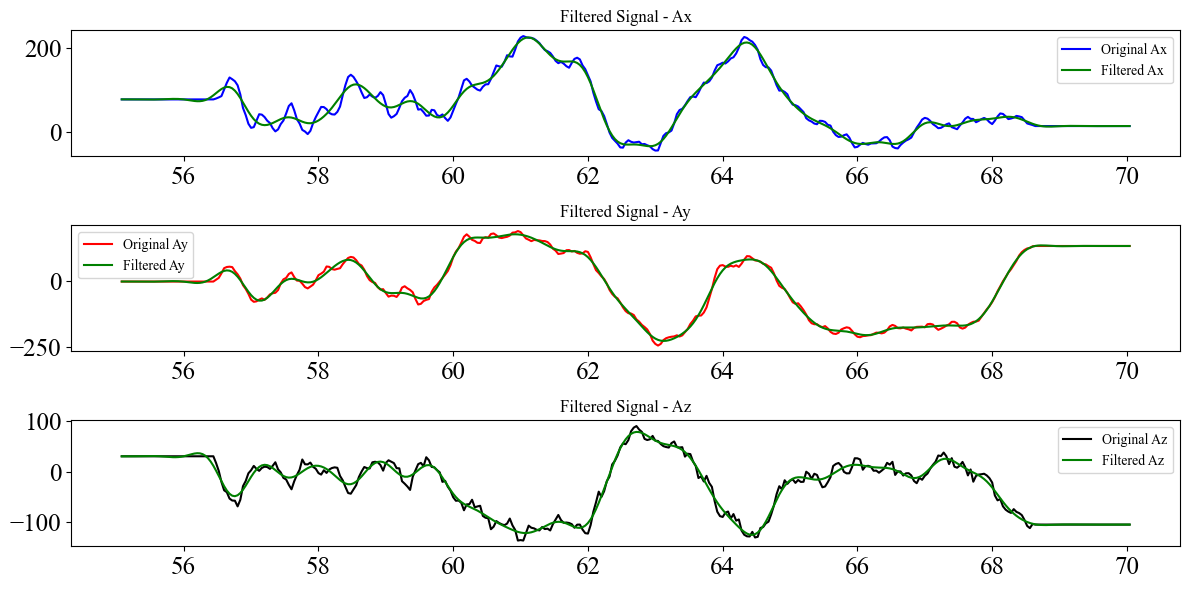

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=4):
    """
    Design a Butterworth low-pass filter.
    
    Parameters:
        cutoff (float): Cutoff frequency of the filter (Hz)
        fs (float): Sampling frequency of the signal (Hz)
        order (int): The order of the filter (Higher order means sharper cutoff)
        
    Returns:
        b, a (ndarray): Numerator and denominator of the filter.
    """
    nyquist = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a Butterworth low-pass filter to the data.
    
    Parameters:
        data (array-like): The signal to be filtered.
        cutoff (float): Cutoff frequency of the filter (Hz)
        fs (float): Sampling frequency of the signal (Hz)
        order (int): The order of the filter (Higher order means sharper cutoff)
        
    Returns:
        y (ndarray): The filtered signal.
    """
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data)
    return y

# Filter settings
cutoff = 1500  # Cutoff frequency of the filter (Hz)
order = 4     # Filter order
fs = 25000

# Applying the Butterworth filter to each axis
ax_filtered = butter_lowpass_filter(Ax, cutoff, fs, order)
ay_filtered = butter_lowpass_filter(Ay, cutoff, fs, order)
az_filtered = butter_lowpass_filter(Az, cutoff, fs, order)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, Ax, 'b-', label='Original Ax')
plt.plot(time, ax_filtered, 'g-', label='Filtered Ax')
plt.legend()
plt.title('Filtered Signal - Ax')

plt.subplot(3, 1, 2)
plt.plot(time, Ay, 'r-', label='Original Ay')
plt.plot(time, ay_filtered, 'g-', label='Filtered Ay')
plt.legend()
plt.title('Filtered Signal - Ay')

plt.subplot(3, 1, 3)
plt.plot(time, Az, 'k-', label='Original Az')
plt.plot(time, az_filtered, 'g-', label='Filtered Az')
plt.legend()
plt.title('Filtered Signal - Az')

plt.tight_layout()
plt.show()


In [17]:
# from scipy.signal import butter, filtfilt
# import matplotlib.pyplot as plt

# def butter_highpass(cutoff, fs, order=4):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='high', analog=False)
#     return b, a

# def butter_lowpass(cutoff, fs, order=4):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
#     """
#     Apply both high-pass and low-pass filters sequentially to achieve band-pass filtering.
#     """
#     # High-pass filtering to remove low-frequency drift
#     b_high, a_high = butter_highpass(lowcut, fs, order)
#     filtered_high = filtfilt(b_high, a_high, data)

#     # Low-pass filtering to remove high-frequency noise
#     b_low, a_low = butter_lowpass(highcut, fs, order)
#     filtered_band = filtfilt(b_low, a_low, filtered_high)
    
#     return filtered_band

# # Filter settings
# lowcut = 100   # High-Pass Filter Cutoff (Remove frequencies below this)
# highcut = 1000   # Low-Pass Filter Cutoff (Remove frequencies above this)
# fs = 25000     # Sampling frequency (Adjust based on your data)
# order = 10       # Order of the filters

# # Apply the band-pass filter to Ax
# ax_filtered = butter_bandpass_filter(Ax.to_numpy(), lowcut, highcut, fs, order)
# ay_filtered = butter_bandpass_filter(Ay.to_numpy(), lowcut, highcut, fs, order)
# az_filtered = butter_bandpass_filter(Az.to_numpy(), lowcut, highcut, fs, order)

# # # Plot the original vs. filtered signal
# # plt.figure(figsize=(12, 6))
# # plt.plot(Ax.to_numpy(), label='Original Ax', color='blue', alpha=0.6)
# # plt.plot(ax_filtered, label=f'Filtered Ax (Band-Pass: {lowcut} - {highcut} Hz)', color='green')
# # plt.title('Original vs. Band-Pass Filtered Signal (Ax)')
# # plt.xlabel('Time (samples)')
# # plt.ylabel('Acceleration [m/s²]')
# # plt.legend()
# # plt.show()

# # Plotting the results
# plt.figure(figsize=(12, 15))
# plt.subplot(3, 1, 1)
# plt.plot(time, Ax, 'b-', label='Original Ax')
# plt.plot(time, ax_filtered, 'g-', label='Filtered Ax')
# plt.legend()
# plt.title('Filtered Signal - Ax')

# plt.subplot(3, 1, 2)
# plt.plot(time, Ay, 'r-', label='Original Ay')
# plt.plot(time, ay_filtered, 'g-', label='Filtered Ay')
# plt.legend()
# plt.title('Filtered Signal - Ay')

# plt.subplot(3, 1, 3)
# plt.plot(time, Az, 'k-', label='Original Az')
# plt.plot(time, az_filtered, 'g-', label='Filtered Az')
# plt.legend()
# plt.title('Filtered Signal - Az')

# plt.tight_layout()
# plt.show()


In [46]:
m = 87.5/1000 # Mass, kg
r = 28.575/1000 #Radius, m
P0 = 6894.76*120 # Stagnation pressure, pa
P = 0.024226295980244256*6894.76 #Static pressure, pa
gamma = 1.4
M = 7.2 #Mach Number
A = np.pi*(r**2) # Reference area, m^2
q_inf = (1/2)*P*gamma*(M**2)  # Stagnation/dynammic pressure of test, Pa
g = 9.81 # Acceleration due to gravity, m/s^2
U_inf = 886.33 # Freestream velocity, m/s
rho= 0.022053985550548307
I_yy = (2/5)*m*(r**2) # Moment of inertia about the pitching axis/center of mass, kgm^2

In [19]:
Cd = (m*np.abs(ax_filtered))/(q_inf*A)
Cl = (m*np.abs(ay_filtered))/(q_inf*A)
Cz = (m*np.abs(az_filtered))/(q_inf*A)

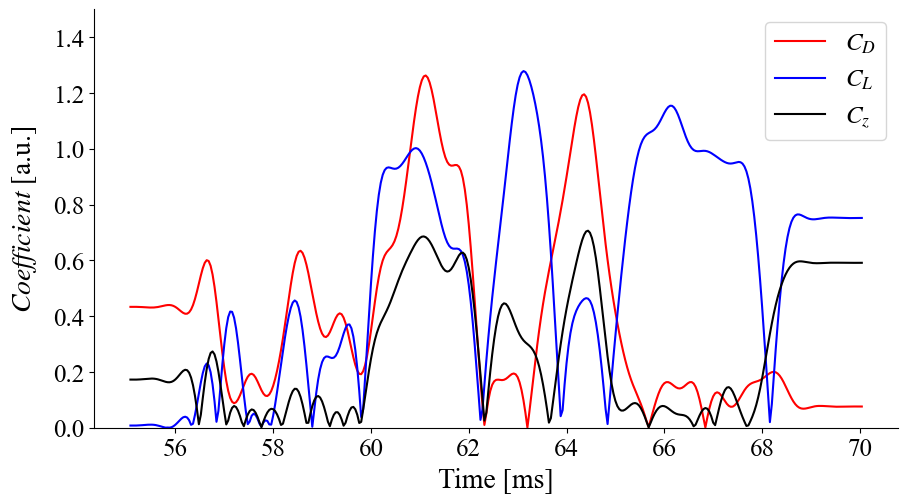

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(time, Cd, 'r', label = r'$C_D$')
plt.plot(time, Cl, 'b', label = r'$C_L$')
plt.plot(time, Cz, 'k', label = r'$C_z$')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$Coefficient$ [a.u.]', rotation = 90, fontsize = 20, labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)
ax.set_ylim(0,1.5)
plt.legend(fontsize = 18)

plt.show()

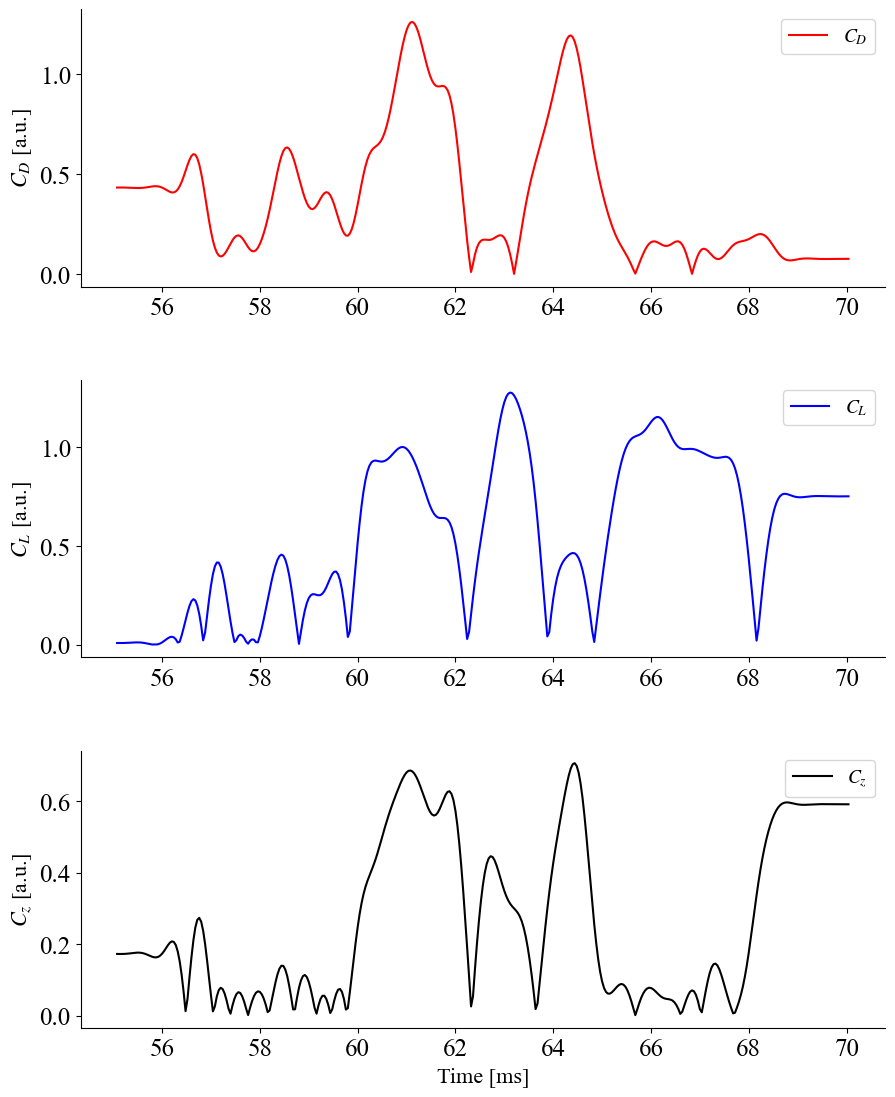

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.tight_layout(pad=5.0)

# Plot C_D
axes[0].plot(time, Cd, 'r', label=r'$C_D$')
axes[0].set_ylabel(r'$C_D$ [a.u.]', fontsize=16)
axes[0].legend(fontsize=14)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

# Plot C_L
axes[1].plot(time, Cl, 'b', label=r'$C_L$')
axes[1].set_ylabel(r'$C_L$ [a.u.]', fontsize=16)
axes[1].legend(fontsize=14)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Plot C_z
axes[2].plot(time, Cz, 'k', label=r'$C_z$')
axes[2].set_xlabel('Time [ms]', fontsize=16)
axes[2].set_ylabel(r'$C_z$ [a.u.]', fontsize=16)
axes[2].legend(fontsize=14)
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].yaxis.set_ticks_position('left')
axes[2].xaxis.set_ticks_position('bottom')

plt.show()


In [22]:
df.columns

Index(['Time', 'X', 'Y', 'Z', 'Vx', 'Vy', 'Vz', 'Ax', 'Ay', 'Az', 'yaw',
       'roll', 'pitch', 'C_D', 'C_L', 'C_z'],
      dtype='object')

In [24]:
df.shape

(375, 16)

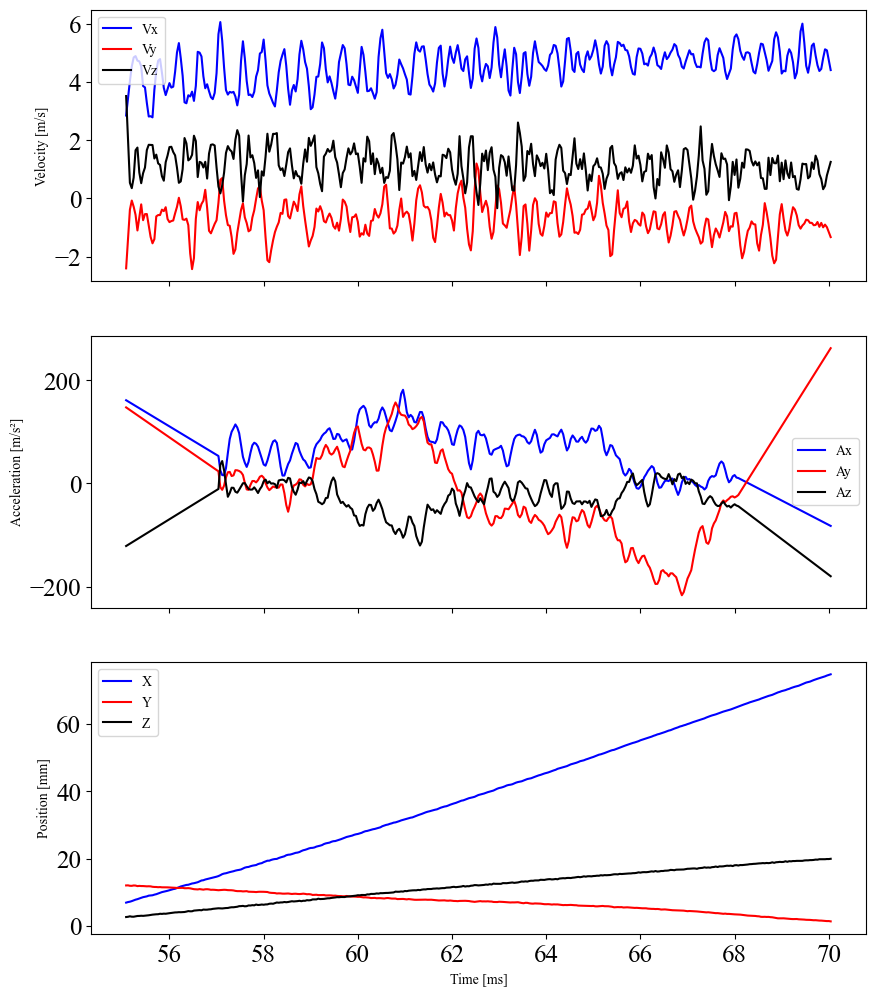

In [55]:
from scipy.signal import savgol_filter

# Sample time and displacement data
# time = np.array([...])  # Time values (ms)
X = df['X'] # X-axis displacement
Y = df['Y']   # Y-axis displacement
Z = df['Z']   # Z-axis displacement
t = df['Time'] 

# Apply Savitzky-Golay filter (a type of moving regression) for smoothing and differentiation
window_size_v = 5  # Use 5-point moving regression
window_size_a = 100 # Use 5-point moving regression
poly_order = 2   # Quadratic fitting

# Compute first derivative (velocity)
Vx = savgol_filter(X, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vy = savgol_filter(Y, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vz = savgol_filter(Z, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))

# Compute second derivative (acceleration)
Ax = savgol_filter(Vx, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Ay = savgol_filter(Vy, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Az = savgol_filter(Vz, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))

# Print or plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax[0].plot(t, Vx, label="Vx", color="b")
ax[0].plot(t, Vy, label="Vy", color="r")
ax[0].plot(t, Vz, label="Vz", color="k")
ax[0].set_ylabel("Velocity [m/s]")
ax[0].legend()

ax[1].plot(t, Ax*1000, label="Ax", color="b")
ax[1].plot(t, Ay*1000, label="Ay", color="r")
ax[1].plot(t, Az*1000, label="Az", color="k")
ax[1].set_ylabel("Acceleration [m/s²]")
ax[1].legend()

ax[2].plot(t, X, label="X", color="b")
ax[2].plot(t, Y, label="Y", color="r")
ax[2].plot(t, Z, label="Z", color="k")
ax[2].set_ylabel("Position [mm]")
ax[2].set_xlabel("Time [ms]")
ax[2].legend()

plt.show()


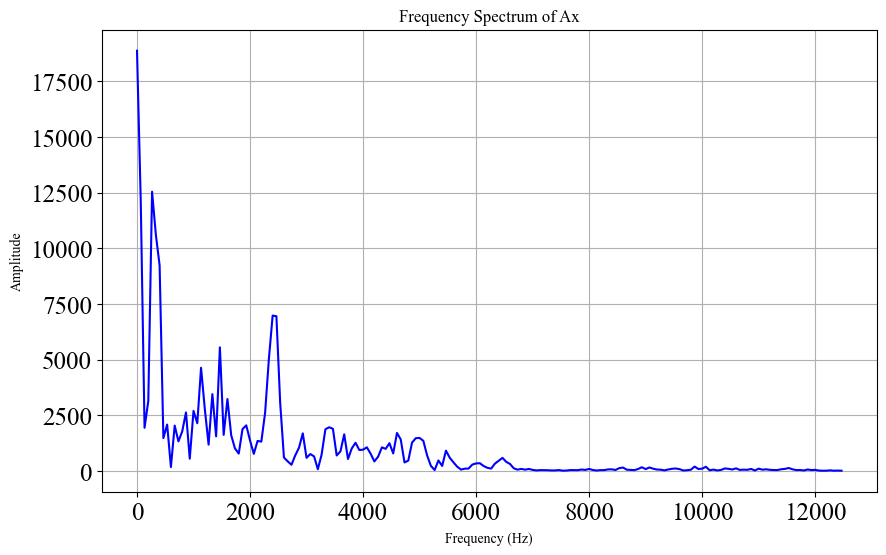

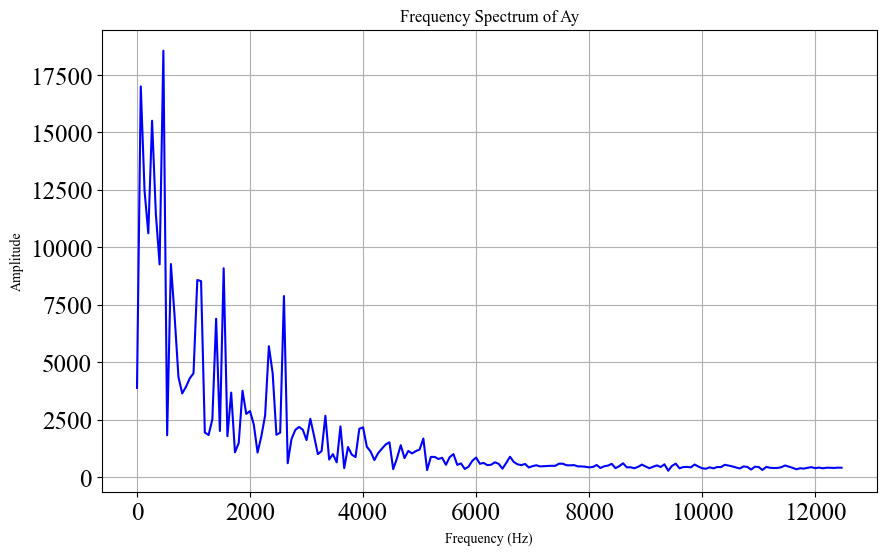

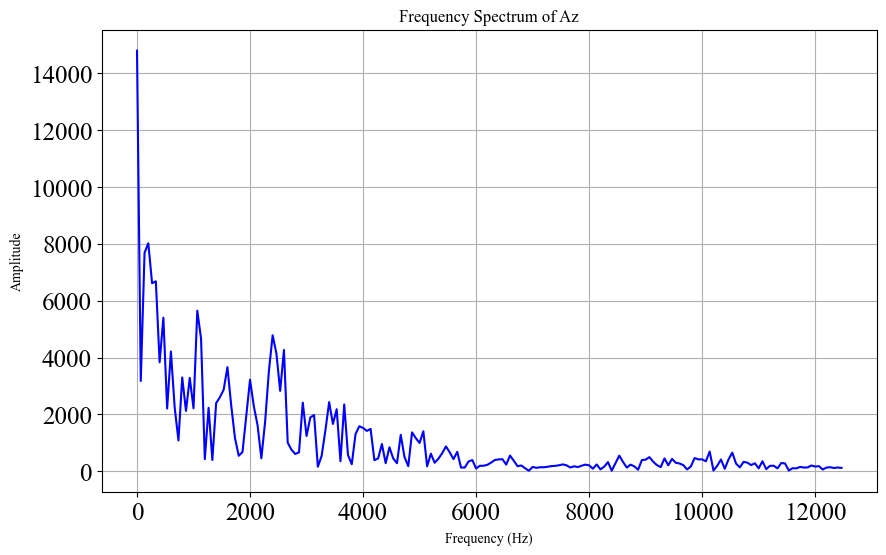

In [38]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_spectrum(data, fs, axis_name="Ax"):
    """
    Plot the frequency spectrum of a signal.
    
    Parameters:
        data (array-like): The signal to be analyzed.
        fs (float): Sampling frequency of the signal (Hz).
        axis_name (str): Name of the axis being plotted (Ax, Ay, Az, etc.)
    """
    # Number of samples
    N = len(data)
    
    # Perform the FFT
    yf = fft(data)
    xf = fftfreq(N, 1 / fs)
    
    # Only keep the positive frequencies
    indices = np.where(xf >= 0)
    xf = xf[indices]
    yf = np.abs(yf[indices])

    # Plot the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(xf, yf, color='blue')
    plt.title(f"Frequency Spectrum of {axis_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


fs = 25000  # Example: If you are sampling your data at 1000 Hz
plot_frequency_spectrum(Ax*1000, fs, axis_name="Ax")
plot_frequency_spectrum(Ay*1000, fs, axis_name="Ay")
plot_frequency_spectrum(Az*1000, fs, axis_name="Az")


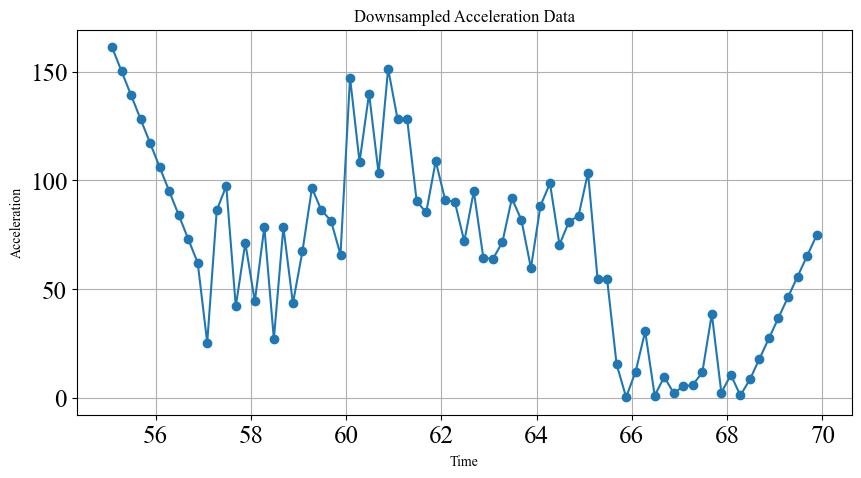

In [56]:
# Suppose your dataframe is named df
# Downsample by taking every 5th data point
acc_x_downsampled = np.abs(Ax[::5]*1000)  # every 5th row from the original 375 gives you ~75 points
time_ds = t[::5]
plt.figure(figsize=(10, 5))
plt.plot(time_ds, acc_x_downsampled, marker='o', linestyle='-')
plt.title('Downsampled Acceleration Data')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.grid(True)
plt.show()



In [58]:
np.mean(Cd)

0.3898545945591048

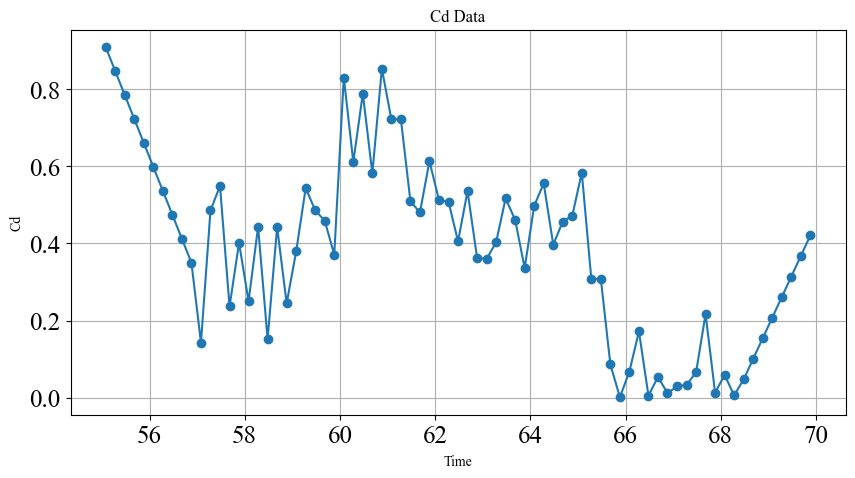

In [57]:
Cd = (m*acc_x_downsampled)/(q_inf*A)

plt.figure(figsize=(10, 5))
plt.plot(time_ds, Cd, marker='o', linestyle='-')
plt.title('Cd Data')
plt.xlabel('Time')
plt.ylabel('Cd')
plt.grid(True)
plt.show()

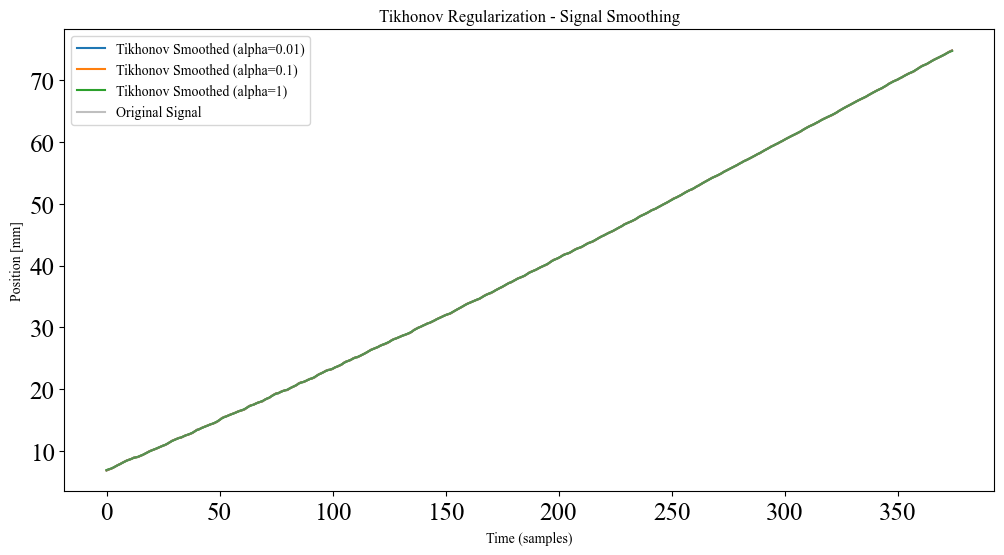

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

def tikhonov_smoothing(data, alpha=0.1, padding=20):
    """
    Apply Tikhonov regularization to smooth a signal with padding.
    
    Parameters:
        data (array-like): The noisy signal to be smoothed.
        alpha (float): Regularization parameter (higher means more smoothing).
        padding (int): Number of points to pad at the beginning and end.
        
    Returns:
        np.ndarray: Smoothed signal.
    """
    N = len(data)
    
    # Add padding to avoid boundary effects
    padded_data = np.pad(data, (padding, padding), mode='edge')
    M = len(padded_data)
    
    I = np.eye(M)
    D = np.diff(I, n=1, axis=0)  # First-order difference matrix
    A = I + alpha * (D.T @ D)
    
    # Solve the regularized problem
    smoothed_data = solve(A, padded_data)
    
    # Remove padding
    smoothed_data = smoothed_data[padding:-padding]
    
    return smoothed_data


# -----------------------------------
# Applying Tikhonov Regularization
# -----------------------------------

# Example Usage: Let's assume 'ax' is your acceleration signal
x_array = X.to_numpy()  # Convert your Pandas Series to NumPy array

# Apply Tikhonov Regularization with different alpha values
alpha_values = [0.01,0.1,1]
plt.figure(figsize=(12, 6))

for alpha in alpha_values:
    ax_smoothed = tikhonov_smoothing(x_array, alpha)
    plt.plot(ax_smoothed, label=f'Tikhonov Smoothed (alpha={alpha})')

# Plot original signal for comparison
plt.plot(x_array, label='Original Signal', color='gray', alpha=0.5)
plt.title('Tikhonov Regularization - Signal Smoothing')
plt.xlabel('Time (samples)')
plt.ylabel('Position [mm]')
plt.legend()
plt.show()
